<a href="https://colab.research.google.com/github/SharlotteManganye/Deep-Learning-CNN/blob/main/Cfar_10_Model2_2025_03_20.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:

# torch- Our deep learning framework
import torch
import torch.nn as nn
from torchvision import datasets
import urllib.request
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Subset, random_split,SubsetRandomSampler
from torch import optim
import torch.nn.functional as F
import math
from sklearn.model_selection import KFold
import numpy as np
import requests
import tarfile
import os
import torchvision
from sklearn.model_selection import KFold
import torch.utils.data
import matplotlib.pyplot as plt
import pandas as pd
import itertools

In [2]:
print(torch.cuda.is_available())  # Should print True if GPU is available
# Check if CUDA is available before getting device name
if torch.cuda.is_available():
    print(torch.cuda.get_device_name(0))  # Prints the name of the GPU using get_device_name
else:
    print("CUDA is not available. No GPU device found.")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

True
Tesla T4


In [3]:

batch_size = 128
epochs = 10
seed = 42 # so I can reproduce the results
epsilon = 1e-8
grad_eps = 1e-3
clip_factor = 0.1
learning_rate = 1e-4
image_height = 28
image_width = 28
input_channels = 3
number_classes= 10
num_folds = 3

In [4]:

def create_train_val_loaders(train_dataset, val_ratio=0.2, batch_size=batch_size, num_workers=2, seed=seed):
    """
    Splits the training data into train and validation sets, creates DataLoaders for train and validation.

    Args:
        train_dataset (torch.utils.data.Dataset): The original training dataset.
        val_ratio (float): The ratio of the training data to use for validation.
        batch_size (int): The batch size for the DataLoaders.
        num_workers (int): The number of workers for the DataLoaders.
        seed (int): The random seed for consistent splits.

    Returns:
        tuple: (train_loader, val_loader)
    """

    total_train_size = len(train_dataset)
    val_size = int(val_ratio * total_train_size)
    train_size = total_train_size - val_size

    generator = torch.Generator().manual_seed(seed)
    train_subset, val_subset = random_split(train_dataset, [train_size, val_size], generator=generator)

    train_loader = DataLoader(
        train_subset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=num_workers,
    )

    val_loader = DataLoader(
        val_subset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=num_workers,
    )

    return train_loader, val_loader


In [5]:

# Load CIFAR-10 dataset
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

train_data = datasets.CIFAR10(
    root='data',
    train=True,
    transform=transform,
    download=True,
)

test_data = datasets.CIFAR10(
    root='data',
    train=False,
    transform=transform
)

100%|██████████| 170M/170M [00:06<00:00, 26.9MB/s]


In [6]:
print(len(train_data))

50000


In [7]:


# Create DataLoaders
train_loader, val_loader = create_train_val_loaders(train_data)
test_loader = torch.utils.data.DataLoader(test_data,
            batch_size=batch_size,
   shuffle=True,

num_workers=1, pin_memory=True) # Pin memory for data)

In [8]:


print(train_data)

Dataset CIFAR10
    Number of datapoints: 50000
    Root location: data
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
           )


In [9]:

print(test_data)

Dataset CIFAR10
    Number of datapoints: 10000
    Root location: data
    Split: Test
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
           )


In [10]:
class PUConv2d(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, padding=0):
        super(PUConv2d, self).__init__()
        self.weights_u = nn.Parameter(torch.Tensor(out_channels, in_channels, kernel_size, kernel_size)) # for positive inputs
        self.weights_v = nn.Parameter(torch.Tensor(out_channels, in_channels, kernel_size, kernel_size)) # for indicator function
        self.stride = stride
        self.padding = padding  # Store the padding value
        # Initialize weights (important!)
        nn.init.kaiming_uniform_(self.weights_u, a=math.sqrt(5))
        nn.init.kaiming_uniform_(self.weights_v, a=math.sqrt(5))

    def forward(self, x):
        # Apply padding before unfolding
        x = F.pad(x, (self.padding, self.padding, self.padding, self.padding))

        batch_size, in_channels, in_height, in_width = x.size()
        kernel_size = self.weights_u.shape[2]
        out_channels = self.weights_u.shape[0]

        out_height = (in_height - kernel_size) // self.stride + 1
        out_width = (in_width - kernel_size) // self.stride + 1

        # Unfold the input tensor
        unfolded = F.unfold(x, kernel_size=kernel_size, stride=self.stride)
        unfolded = unfolded.view(batch_size, in_channels * kernel_size * kernel_size, out_height * out_width)

        # Weights for positive input component
        weights_u_reshaped = self.weights_u.view(out_channels, -1)

        # Logarithm of absolute value
        log_abs_unfolded = torch.log(torch.abs(unfolded) + epsilon)  # Add small constant for numerical stability

        # Compute the exponential part (corresponding to Eq. 3)
        exp_term = torch.exp(torch.einsum("oc,bcp->bop", weights_u_reshaped, log_abs_unfolded))

        # Weights for indicator function
        weights_v_reshaped = self.weights_v.view(out_channels, -1)

        # Indicator function (vectorized)
        indicator = (unfolded < 0).float()

        # Compute the cosine term (corresponding to Eq. 4)
        cosine_term = torch.cos(math.pi * torch.einsum("oc,bcp->bop", weights_v_reshaped, indicator)).view(batch_size, out_channels, out_height, out_width)

        # Combine the terms
        output = exp_term.view(batch_size, out_channels, out_height, out_width) * cosine_term

        return output

In [11]:
class SigmaPUConv2d(nn.Module):
    def __init__(self, in_channels= input_channels, num_classes=number_classes, image_height=image_height, image_width=image_width):
        super(SigmaPUConv2d, self).__init__()
        self.product_conv1 = PUConv2d(in_channels, 16, kernel_size=3)
        self.conv1 = nn.Conv2d(in_channels, 16, 3)
        self.bn1_prod = nn.BatchNorm2d(16)
        self.bn1 = nn.BatchNorm2d(16)
        self.dropout1 = nn.Dropout(0.25)

        self.product_conv2 = PUConv2d(32, 32, kernel_size=3)
        self.conv2 = nn.Conv2d(32, 32, 3)
        self.bn2_prod = nn.BatchNorm2d(32)
        self.bn2 = nn.BatchNorm2d(32)
        self.dropout2 = nn.Dropout(0.25)

        self.product_conv3 = PUConv2d(64, 64, kernel_size=3)
        self.conv3 = nn.Conv2d(64, 64, 3)
        self.bn3_prod = nn.BatchNorm2d(64)
        self.bn3 = nn.BatchNorm2d(64)
        self.dropout3 = nn.Dropout(0.25)

        self.product_conv4 = PUConv2d(128, 128, kernel_size=3)
        self.conv4 = nn.Conv2d(128, 128, 3)
        self.bn4_prod = nn.BatchNorm2d(128)
        self.bn4 = nn.BatchNorm2d(128)
        self.dropout4 = nn.Dropout(0.25)

        self.bn_final = nn.BatchNorm2d(256)

        self.image_height = image_height
        self.image_width = image_width

        self.fc_input_size = self._calculate_fc_input_size()

        self.fc_model = nn.Sequential(
            nn.Linear( self.fc_input_size, 128),  # Use fc_input_size here
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, num_classes)
            )
    def _conv_block(self, x, conv, bn, pool=True):
        x = conv(x)
        x = bn(x)
        x = F.relu(x)
        if pool:
            x = F.max_pool2d(x, 2)
        return x

    def _calculate_fc_input_size(self):
        dummy_input = torch.randn(1, input_channels, self.image_height, self.image_width) #Correct input size

        y = self._conv_block(dummy_input, self.product_conv1, self.bn1_prod, pool=False)
        z = self._conv_block(dummy_input, self.conv1, self.bn1, pool=False)
        combined_features = torch.cat((y, z), dim=1)

        y2 = self._conv_block(combined_features, self.product_conv2, self.bn2_prod, pool=False)
        z2 = self._conv_block(combined_features, self.conv2, self.bn2, pool=False)
        combined_features2 = torch.cat((y2, z2), dim=1)

        y3 = self._conv_block(combined_features2, self.product_conv3, self.bn3_prod, pool=False)
        z3 = self._conv_block(combined_features2, self.conv3, self.bn3, pool=False)
        combined_features3 = torch.cat((y3, z3), dim=1)

        y4 = self._conv_block(combined_features3, self.product_conv4, self.bn4_prod)
        z4 = self._conv_block(combined_features3, self.conv4, self.bn4)
        combined_features4 = torch.cat((y4, z4), dim=1)

        combined_features4 = self.bn_final(combined_features4)
        combined_features4 = F.relu(combined_features4)
        combined_features4 = F.adaptive_avg_pool2d(combined_features4, (7, 7)) # Apply adaptive pooling before calculating size

        return combined_features4.view(1, -1).size(1)

    def forward(self, x, return_feature_maps=False):
        y = self._conv_block(x, self.product_conv1, self.bn1_prod, pool=False)
        z = self._conv_block(x, self.conv1, self.bn1, pool=False)
        combined_features = torch.cat((y, z), dim=1)

        y2 = self._conv_block(combined_features, self.product_conv2, self.bn2_prod, pool=False)
        z2 = self._conv_block(combined_features, self.conv2, self.bn2, pool=False)
        combined_features2 = torch.cat((y2, z2), dim=1)

        y3 = self._conv_block(combined_features2, self.product_conv3, self.bn3_prod, pool=False)
        z3 = self._conv_block(combined_features2, self.conv3, self.bn3, pool=False)
        combined_features3 = torch.cat((y3, z3), dim=1)

        y4 = self._conv_block(combined_features3, self.product_conv4, self.bn4_prod)
        z4 = self._conv_block(combined_features3, self.conv4, self.bn4)
        combined_features4 = torch.cat((y4, z4), dim=1)

        combined_features4 = self.bn_final(combined_features4)
        combined_features4 = F.relu(combined_features4)

        # Use adaptive pooling to get a fixed output size
        combined_features4 = F.adaptive_avg_pool2d(combined_features4, (7, 7))

        combined_features4 = combined_features4.view(combined_features4.size(0), -1)



        x = self.fc_model(combined_features4)
        output = F.log_softmax(x, dim=1)

        if return_feature_maps:
            return output, y2, z2, combined_features3
        else:
            return output

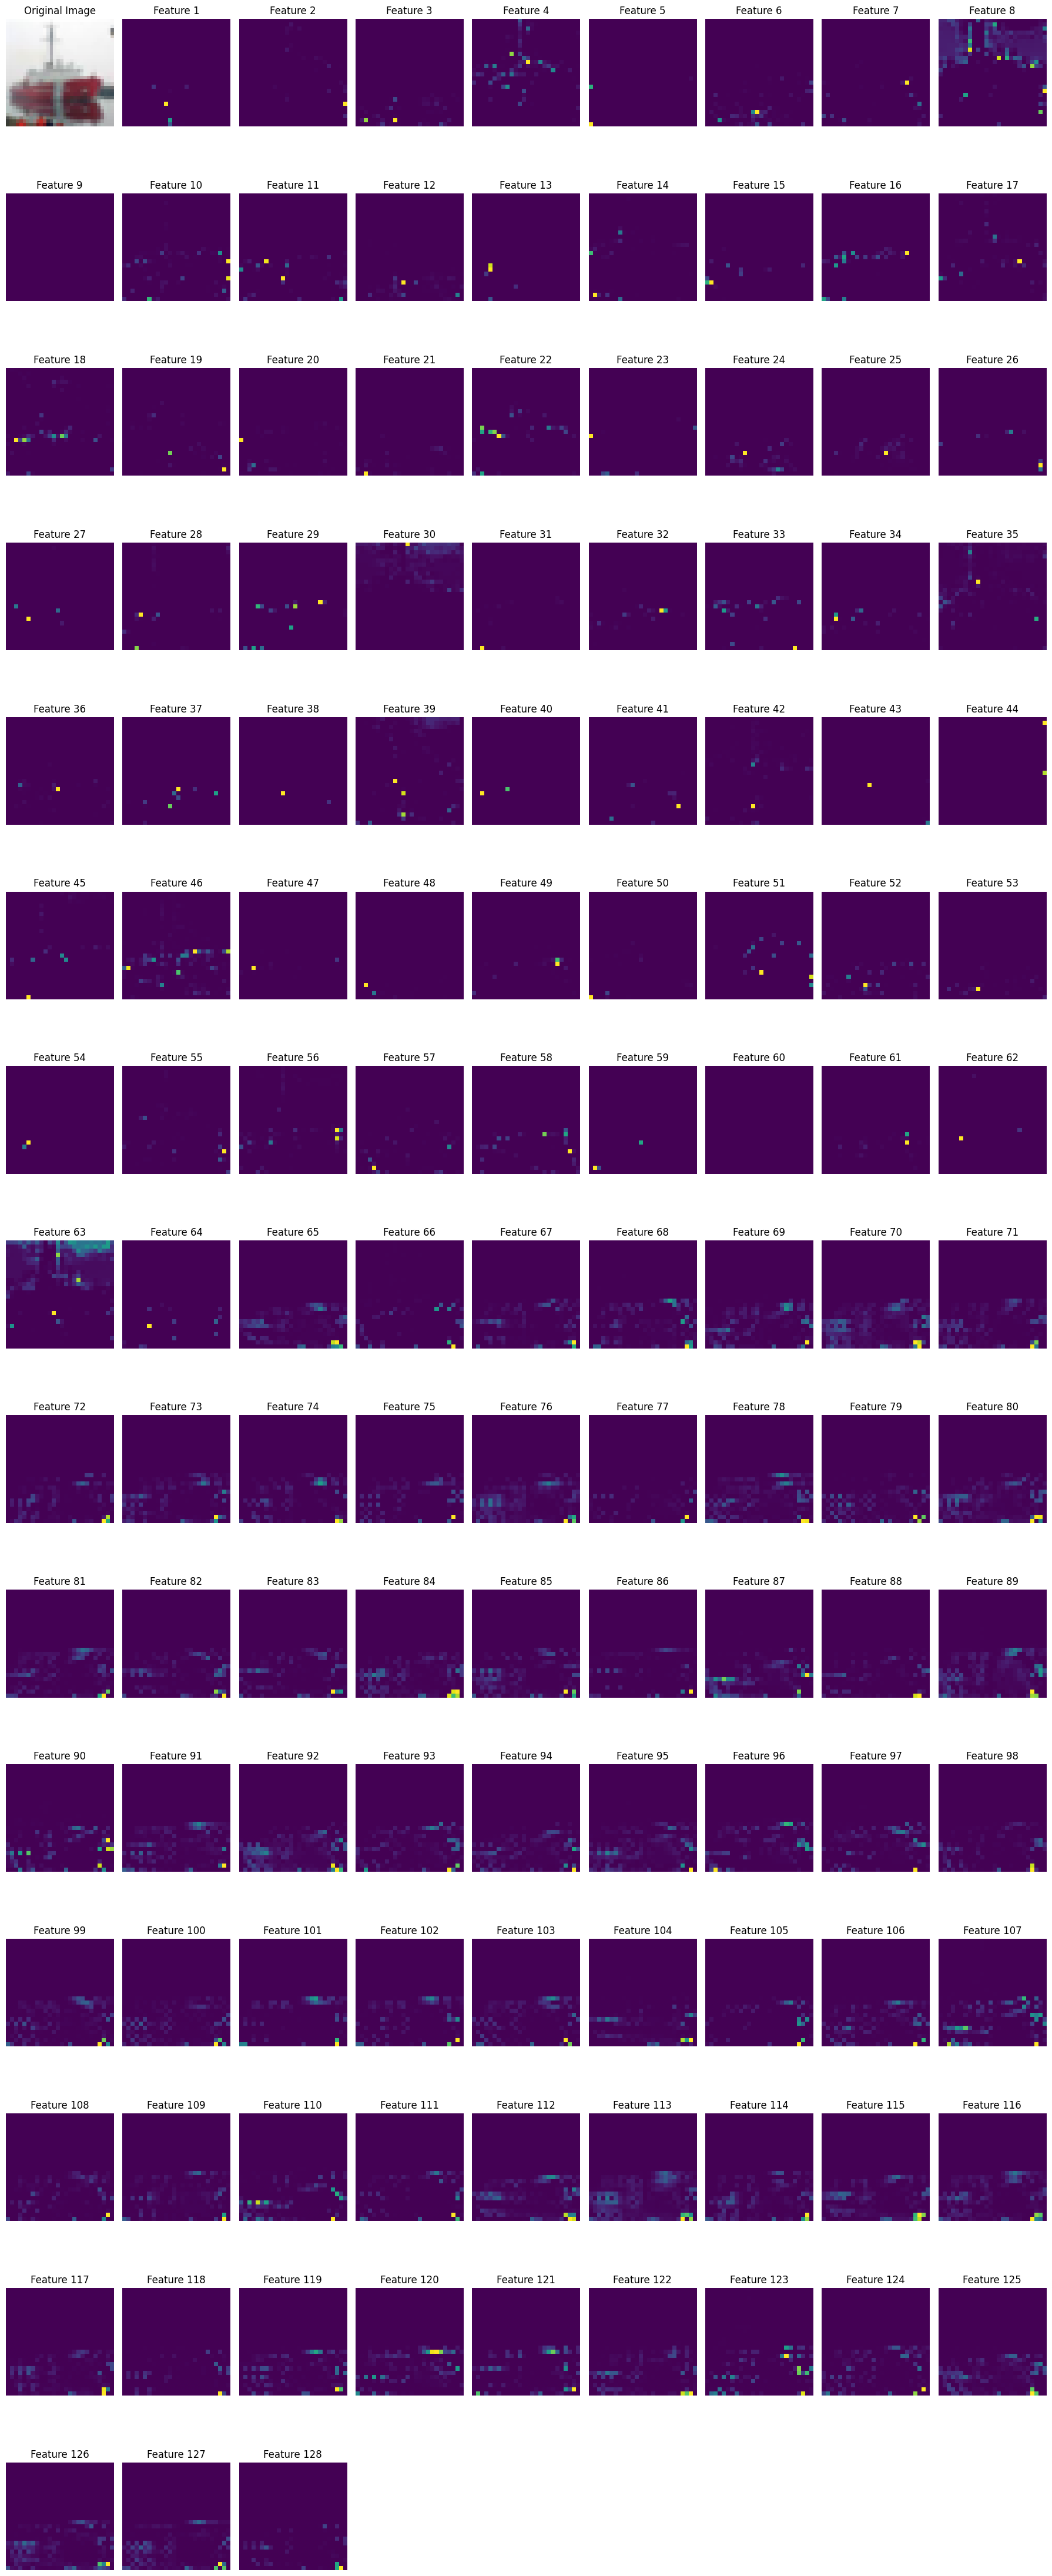

In [12]:
# %%
# Assuming train_loader is already defined
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = SigmaPUConv2d().to(device)
model.eval()

data_iter = iter(train_loader)
image, label = next(data_iter)
image = image.to(device)

output, prod_conv_features, conv1_features, combined_features3 = model(image, return_feature_maps=True)

# Limit the number of features to display
num_features_to_display = combined_features3.shape[1]

# Calculate the subplot grid dimensions based on num_features_to_display
num_cols = min(9, num_features_to_display)  # Maximum 9 columns
num_rows = (num_features_to_display + num_cols - 1) // num_cols  # Calculate rows

plt.figure(figsize=(18, 3 * num_rows))  # Adjust figure height for more rows

plt.subplot(num_rows, num_cols, 1)  # Subplot for the original image
plt.imshow(np.transpose(image[0].cpu().numpy(), (1, 2, 0)) * 0.5 + 0.5)
plt.title("Original Image")
plt.axis('off')

# Loop through the features to display
for i in range(num_features_to_display):
    # Calculate the subplot index, ensuring it stays within the valid range
    subplot_index = i + 2
    plt.subplot(num_rows, num_cols, subplot_index)  # Use calculated grid
    plt.imshow(combined_features3[0, i].detach().cpu().numpy(), cmap='viridis')
    plt.title(f'Feature {i + 1}')
    plt.axis('off')

plt.tight_layout()
plt.show()
# %%

--- Epoch 1 ---
epoch: 1, train_acc: 22.2875
	Train loss: 2.1016, acc: 22.2875%
	Val loss: 1.9051, acc: 35.7200%
--- Epoch 2 ---
epoch: 1, train_acc: 38.09
	Train loss: 1.7002, acc: 38.0900%
	Val loss: 1.6557, acc: 43.0700%
--- Epoch 3 ---
epoch: 1, train_acc: 44.6725
	Train loss: 1.5317, acc: 44.6725%
	Val loss: 1.6245, acc: 45.7100%
--- Epoch 4 ---
epoch: 1, train_acc: 48.8325
	Train loss: 1.4254, acc: 48.8325%
	Val loss: 1.5004, acc: 50.0300%
--- Epoch 5 ---
epoch: 1, train_acc: 51.85
	Train loss: 1.3484, acc: 51.8500%
	Val loss: 1.4347, acc: 51.4600%
--- Epoch 6 ---
epoch: 1, train_acc: 53.8175
	Train loss: 1.2931, acc: 53.8175%
	Val loss: 1.4238, acc: 52.4300%
--- Epoch 7 ---
epoch: 1, train_acc: 55.9775
	Train loss: 1.2426, acc: 55.9775%
	Val loss: 1.3881, acc: 54.2500%
--- Epoch 8 ---
epoch: 1, train_acc: 57.5175
	Train loss: 1.1885, acc: 57.5175%
	Val loss: 1.3583, acc: 54.8200%
--- Epoch 9 ---
epoch: 1, train_acc: 59.48
	Train loss: 1.1454, acc: 59.4800%
	Val loss: 1.3540, acc

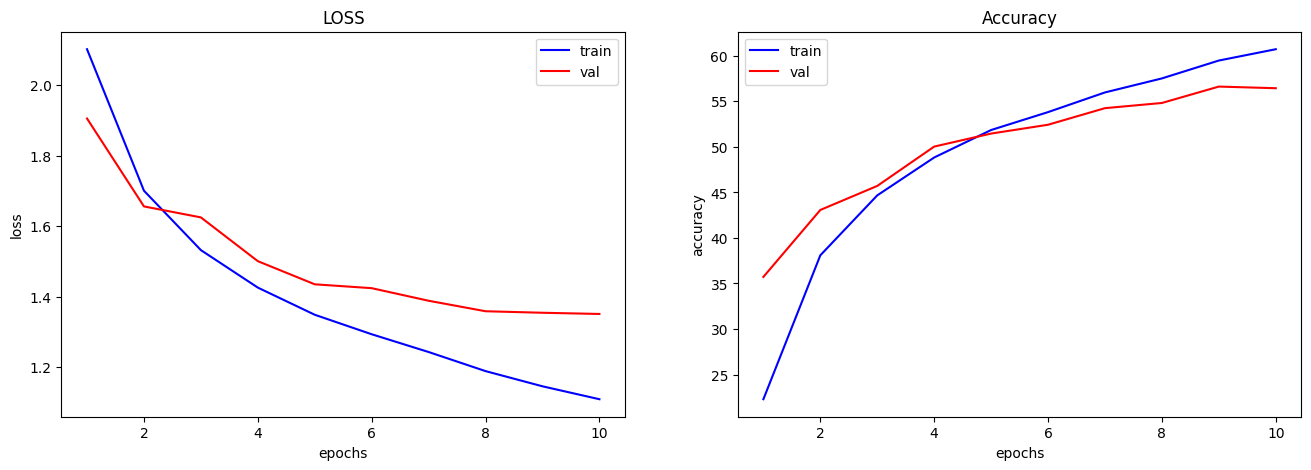

In [15]:

model = SigmaPUConv2d().to(device)
loss_func = nn.CrossEntropyLoss()
# Adam optimizer
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Alternative Adaptive Gradient Clipping (Norm Based)
def adaptive_clip_grad_norm(parameters, clip_factor=clip_factor, eps=grad_eps):
    if not isinstance(parameters, torch.Tensor):
        parameters = list(filter(lambda p: p.grad is not None, parameters))
    if not parameters:
        return

    device = parameters[0].device
    total_norm = torch.norm(torch.stack([torch.norm(p.grad.detach()).to(device) for p in parameters]))
    clip_coef = (clip_factor * total_norm) / (total_norm + eps)
    if clip_coef < 1:
        for p in parameters:
            p.grad.detach().mul_(clip_coef.to(p.grad.device))

# Train function (adapted)
def train(model, train_loader, optimizer, loss_func, epochs, device):
    model.train()
    train_loss = 0
    for epoch in range(epochs):
        train_acc = 0 # reset train_acc at the beginning of each epoch.
        for data, target in train_loader:
            data, target = data.to(device), target.to(device)

            optimizer.zero_grad()
            output = model(data.float())

            loss = loss_func(output, target)
            loss.backward()

            # Apply gradient clipping
            adaptive_clip_grad_norm(model.parameters())

            optimizer.step()

            train_loss += loss.item()

            _, pred = output.max(1)
            train_acc += target.eq(pred).sum().item()

        avg_train_loss = train_loss / len(train_loader)
        avg_train_acc = 100. * train_acc / len(train_loader.dataset)
        print (f'epoch: {epoch+1}, train_acc: {avg_train_acc}')

    return avg_train_loss, avg_train_acc

# Validation function (adapted)
def val(model, val_loader, loss_func, device):
    model.eval()
    val_loss = 0
    val_acc = 0
    with torch.no_grad():
        for data, target in val_loader:
            data, target = data.to(device), target.to(device)
            output = model(data.float())

            loss = loss_func(output, target)
            val_loss += loss.item()

            _, pred = output.max(1)
            val_acc += target.eq(pred).sum().item()

    avg_val_loss = val_loss / len(val_loader)
    avg_val_acc = 100. * val_acc / len(val_loader.dataset)

    return avg_val_loss, avg_val_acc


###PLOT
loss_list = []
val_loss_list = []

acc_list = []
val_acc_list = []

for epoch in range(1, epochs + 1):
    print("--- Epoch {} ---".format(epoch))

    train_loss, train_acc = train(model, train_loader, optimizer, loss_func, 1, device)
    print('\tTrain loss: {:.4f}, acc: {:.4f}%'.format(train_loss, train_acc))
    loss_list.append(train_loss)
    acc_list.append(train_acc)

    val_loss, val_acc = val(model, val_loader, loss_func, device)
    print('\tVal loss: {:.4f}, acc: {:.4f}%'.format(val_loss, val_acc))
    val_loss_list.append(val_loss)
    val_acc_list.append(val_acc)

# plot

x = range(1, epochs + 1)

plt.figure(figsize=(16, 5))

# loss
plt.subplot(1, 2, 1)
plt.plot(x, loss_list, 'b', label='train')
plt.plot(x, val_loss_list, 'r', label='val')
plt.title('LOSS')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()

# Accuracy
plt.subplot(1, 2, 2)
plt.plot(x, acc_list, 'b', label='train')
plt.plot(x, val_acc_list, 'r', label='val')
plt.title('Accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()
plt.show()

In [19]:
# Cross-validation function

def cross_validate(model, dataset, num_folds=num_folds, batch_size=batch_size, epochs=epochs, device='cuda', seed=42):


    # Now perform KFold on the train_dataset only
    kf = KFold(n_splits=num_folds, shuffle=True, random_state=seed)

    fold_train_losses = []
    fold_val_losses = []
    fold_train_accuracies = []
    fold_val_accuracies = []

    for fold, (train_idx, val_idx) in enumerate(kf.split(dataset)):  # Use train_dataset here
        print(f"Fold {fold + 1}/{num_folds}")

        # Split the train_dataset into train and validation subsets using the indices from KFold
        train_subset = Subset(dataset, train_idx)
        val_subset = Subset(dataset, val_idx)

        train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
        val_loader = DataLoader(val_subset, batch_size=batch_size, shuffle=False)

        # Reinitialize the model for each fold
        model =  SigmaPUConv2d().to(device)
        optimizer = optim.Adam(model.parameters(), lr=learning_rate)
        loss_func = nn.CrossEntropyLoss()

        # Train the model for the current fold
        fold_train_loss, fold_train_acc = train(model, train_loader, optimizer, loss_func, epochs, device)
        fold_val_loss, fold_val_acc = val(model, val_loader, loss_func, device)

        # Store the results
        fold_train_losses.append(fold_train_loss)
        fold_val_losses.append(fold_val_loss)
        fold_train_accuracies.append(fold_train_acc)
        fold_val_accuracies.append(fold_val_acc)

        # Print the training accuracy for the current fold
        print(f"  Fold {fold + 1} Train Accuracy: {fold_train_acc:.4f}")

    # Calculate averages and standard deviations across all folds
    avg_train_loss = np.mean(fold_train_losses)
    std_train_loss = np.std(fold_train_losses)
    avg_val_loss = np.mean(fold_val_losses)
    std_val_loss = np.std(fold_val_losses)

    avg_train_acc = np.mean(fold_train_accuracies)
    std_train_acc = np.std(fold_train_accuracies)
    avg_val_acc = np.mean(fold_val_accuracies)
    std_val_acc = np.std(fold_val_accuracies)

    # Print results
    print(f"\n--- Cross-validation Results ---")
    print(f"Average Train Loss: {avg_train_loss:.4f}, Std Train Loss: {std_train_loss:.4f}")
    print(f"Average Validation Loss: {avg_val_loss:.4f}, Std Validation Loss: {std_val_loss:.4f}")
    print(f"Average Train Accuracy: {avg_train_acc:.4f}, Std Train Accuracy: {std_train_acc:.4f}")
    print(f"Average Validation Accuracy: {avg_val_acc:.4f}, Std Validation Accuracy: {std_val_acc:.4f}")

 # Collect results for export to Excel
    fold_results = []
    for i in range(num_folds):
        fold_results.append({
            'Fold': i + 1,
            'Train Loss': fold_train_losses[i],
            'Val Loss': fold_val_losses[i],
            'Train Accuracy': fold_train_accuracies[i],
            'Val Accuracy': fold_val_accuracies[i]
        })

    # Create DataFrame from the fold results
    fold_df = pd.DataFrame(fold_results)

    # Add averages and standard deviations as new rows at the end
    avg_std_results = {
        'Fold': 'Average',
        'Train Loss': avg_train_loss,
        'Val Loss': avg_val_loss,
        'Train Accuracy': avg_train_acc,
        'Val Accuracy': avg_val_acc
    }

    std_results = {
        'Fold': 'Std Dev',
        'Train Loss': std_train_loss,
        'Val Loss': std_val_loss,
        'Train Accuracy': std_train_acc,
        'Val Accuracy': std_val_acc
    }
    fold_df = pd.concat([fold_df, pd.DataFrame([avg_std_results, std_results])], ignore_index=True)

    # Export the table to an Excel file
    fold_df.to_csv('cross_validation_results_lr004.csv', index=False)

    files.download('cross_validation_results_lr004.csv')

    return (avg_train_loss, std_train_loss, avg_val_loss, std_val_loss,
            avg_train_acc, std_train_acc, avg_val_acc, std_val_acc)


In [ ]:

cross_validate(model, train_data)

Fold 1/3
epoch: 1, train_acc: 21.43521435214352
epoch: 2, train_acc: 37.494374943749435
epoch: 3, train_acc: 44.27744277442775
epoch: 4, train_acc: 47.92247922479225
epoch: 5, train_acc: 50.72150721507215
epoch: 6, train_acc: 53.046530465304656
epoch: 7, train_acc: 54.59754597545975
epoch: 8, train_acc: 56.64056640566405
epoch: 9, train_acc: 58.206582065820655
epoch: 10, train_acc: 59.20259202592026
  Fold 1 Train Accuracy: 59.2026
Fold 2/3
epoch: 1, train_acc: 22.32022320223202
